https://www.dataquest.io/blog/tutorial-colors-image-clustering-python/  
https://medium.com/@h4k1m0u/clustering-a-satellite-image-with-scikit-learn-14adb2ca3790  
http://www.acgeospatial.co.uk/k-means-sentinel-2-python/    
Boden Viewer http://bodenviewer.hessen.de/mapapps/resources/apps/bodenviewer/index.html?lang=de


# 1 Band Classifier Read image with GDAL wrapper in a Numpy array and extract band 

In [17]:
filepath = r'C:\Users\USER\Desktop\master-thesis-master\soil_map\results\soil_map_middle_hesse_clean_ref.tif'
print(filepath)


C:\Users\USER\Desktop\master-thesis-master\soil_map\results\soil_map_middle_hesse_clean_ref.tif


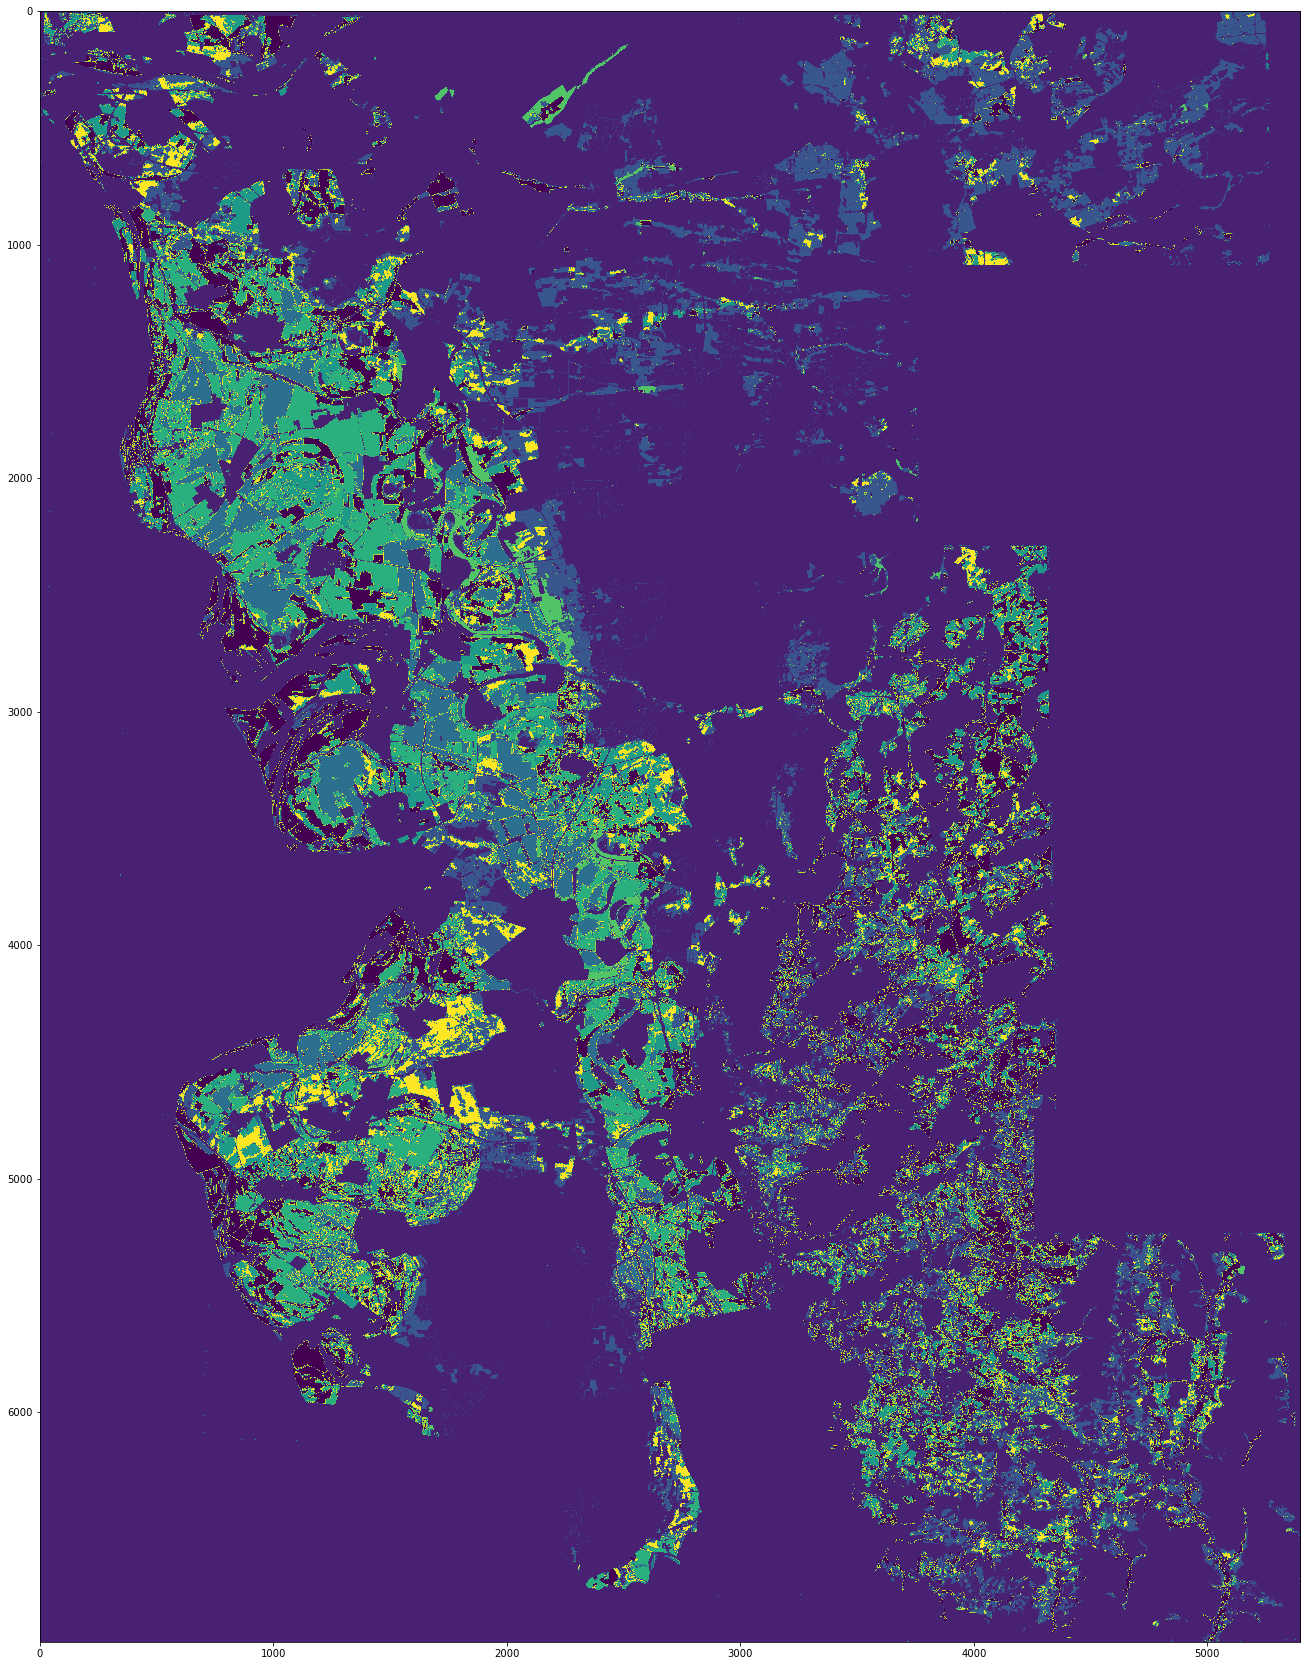

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import cluster
import numpy as np
from osgeo import gdal, gdal_array

print(filepath)
dataset = gdal.Open(filepath, gdal.GA_ReadOnly)
band = dataset.GetRasterBand(2)
img = band.ReadAsArray()

img_1d = img.reshape((-1,1))
img_1d = np.where(img_1d==150, 255, img_1d) 
img_1d = np.where(img_1d==0, 255, img_1d) 


k_means = cluster.KMeans(n_clusters=12)
k_means.fit(img_1d)

#Assign labels
cluster = k_means.labels_
#reshape to original dimensions
cluster = cluster.reshape(img.shape)

plt.figure(figsize=(30,30))
plt.imshow(cluster)
plt.show()



# All Band classifier 

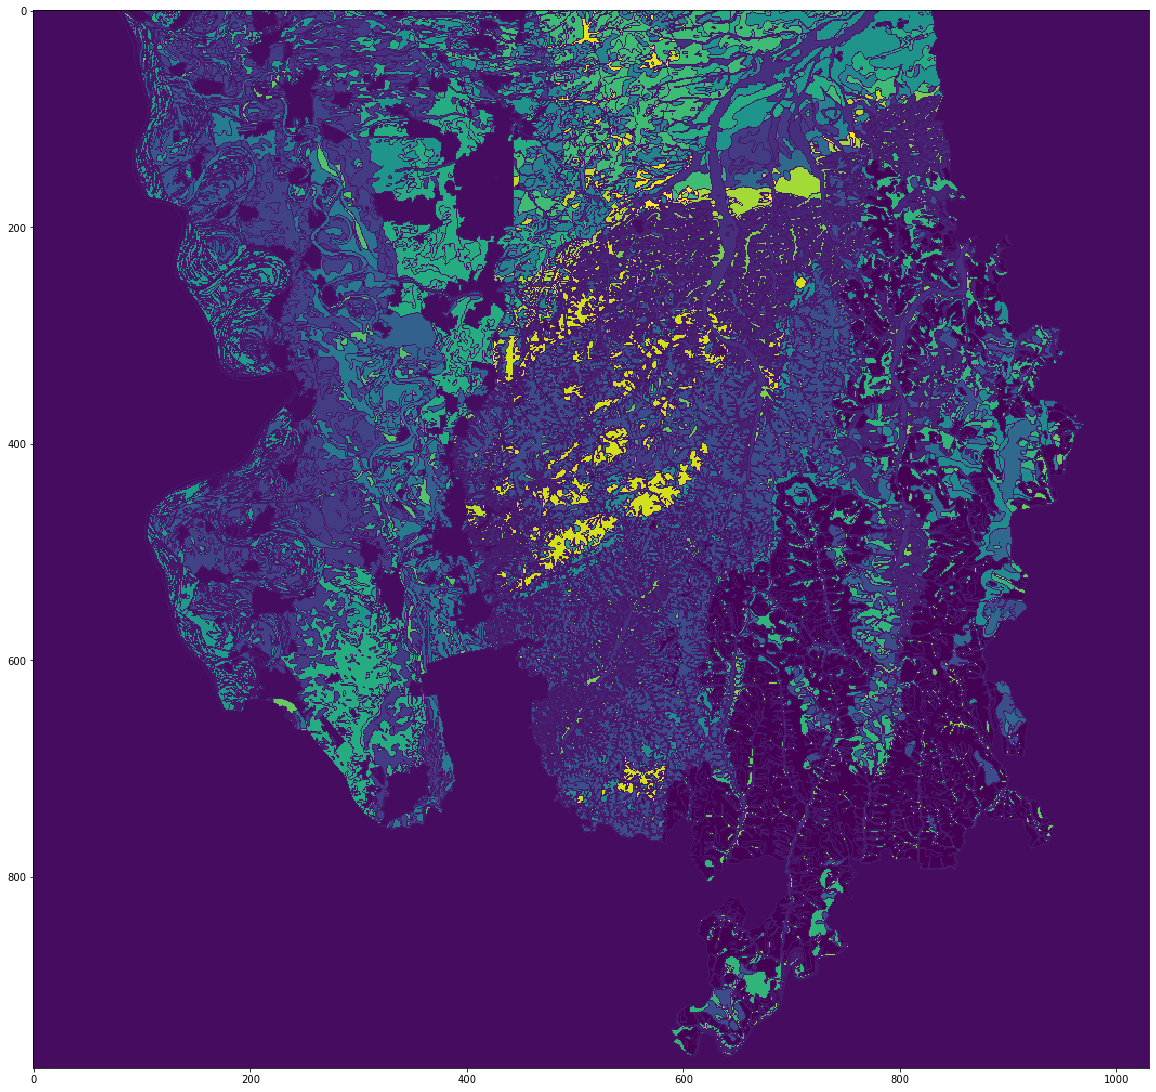

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import cluster
import numpy as np
from osgeo import gdal, gdal_array
gdal.UseExceptions()
gdal.AllRegister()
import os

#Load file in gdal
file = gdal.Open(filepath, gdal.GA_ReadOnly)

#Initialize an array of zeros with size of input
img = np.zeros((file.RasterYSize, file.RasterXSize, file.RasterCount), gdal_array.GDALTypeCodeToNumericTypeCode(file.GetRasterBand(1).DataType))

#Loop over the number of bands in the image (img.shape[2]) insert values into the numpy array
for b in range(img.shape[2]):
    img[ : , : , b] = file.GetRasterBand(b + 1).ReadAsArray()

#Reshape array 
new_shape = (img.shape[0] * img.shape[1], img.shape[2])

#based on this shape, we can build the input value
X = img[: , : , :3].reshape(new_shape)
#X = np.where(X==150, 255, X) Bad idea because other r ,g or b values may have same as black and gray
#X = np.where(X==0, 255, X) 

#Classifier Kmeans
k_means = cluster.KMeans(n_clusters=30)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

#Plot the data
plt.figure(figsize=(20,20))
plt.imshow(X_cluster)

plt.show()


Color: [202. 232. 255.]  >>  Objects: 152
Color: [150. 150. 150.]  >>  Objects: 4114
Color: [255. 223. 166.]  >>  Objects: 638
Color: [255. 255. 255.]  >>  Objects: 158
Color: [232. 175. 115.]  >>  Objects: 199
Color: [255. 235. 136.]  >>  Objects: 833
Color: [217. 146.  77.]  >>  Objects: 521
Color: [248. 207. 134.]  >>  Objects: 299
Color: [196. 182. 228.]  >>  Objects: 95
Color: [237. 205.  77.]  >>  Objects: 169
Color: [175. 214. 132.]  >>  Objects: 55
Color: [232. 139. 120.]  >>  Objects: 112
Color: [175. 145. 100.]  >>  Objects: 78
Color: [233. 209. 182.]  >>  Objects: 203
Color: [203. 217. 223.]  >>  Objects: 128
Color: [255. 237. 194.]  >>  Objects: 151
Color: [155. 196. 225.]  >>  Objects: 25
Color: [255. 233. 115.]  >>  Objects: 121
Color: [255. 228. 154.]  >>  Objects: 304
Color: [187. 142. 126.]  >>  Objects: 43
Color: [242. 219. 161.]  >>  Objects: 263
Color: [223. 168. 127.]  >>  Objects: 29
Color: [255. 232. 177.]  >>  Objects: 131
Color: [237. 182. 208.]  >>  Objects: 2

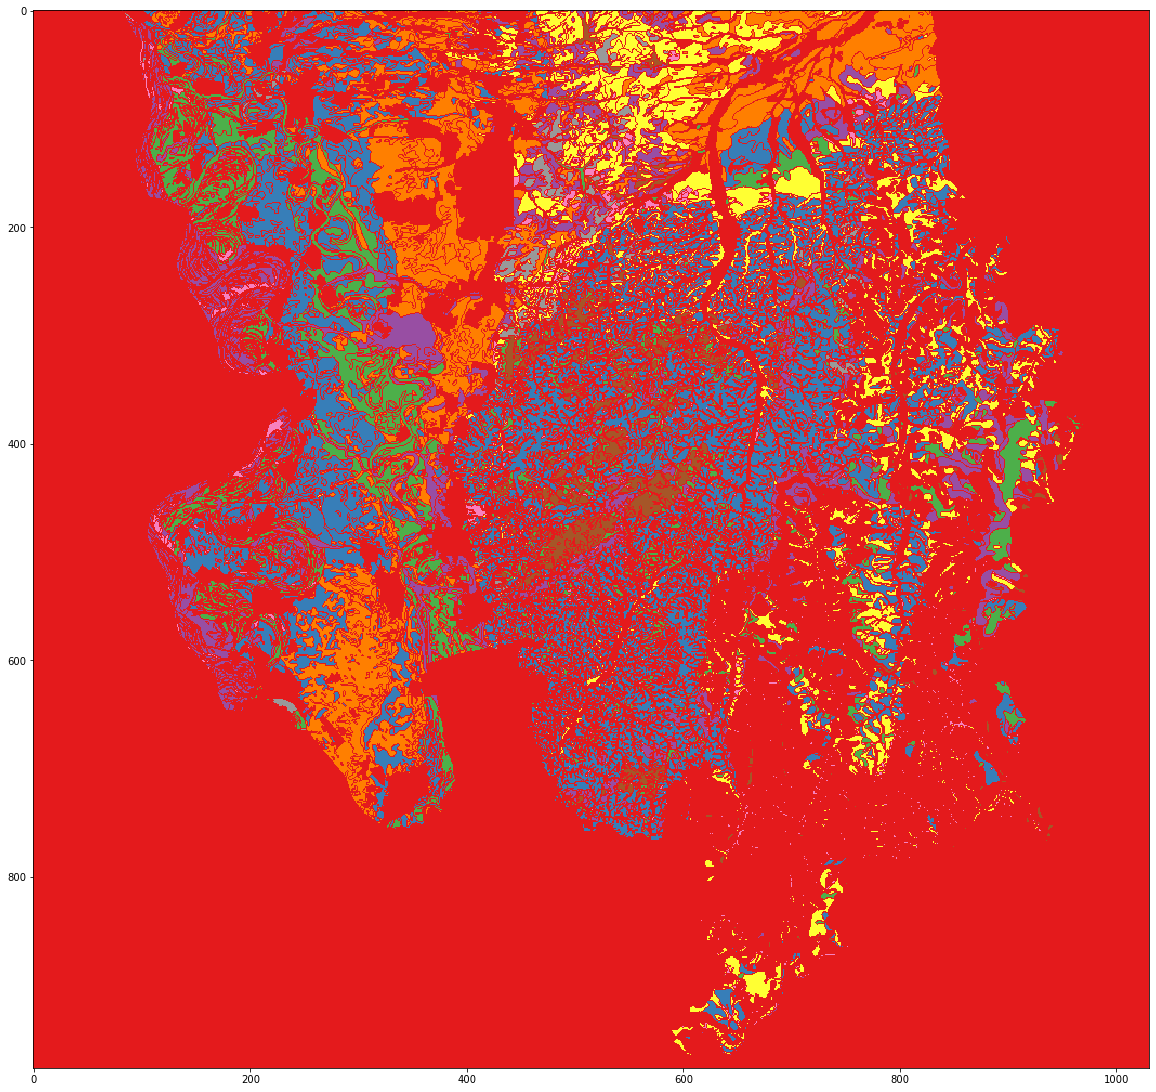

In [25]:
import numpy as np
from skimage import io, morphology, measure
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
img = io.imread(filepath)

rows, cols, bands = img.shape
X = img.reshape(rows*cols, bands)

kmeans = KMeans(n_clusters=35, random_state=0).fit(X)
labels = kmeans.labels_.reshape(rows, cols)

for i in np.unique(labels):
    blobs = np.int_(morphology.binary_opening(labels == i))
    color = np.around(kmeans.cluster_centers_[i])
    count = len(np.unique(measure.label(blobs))) - 1
    print('Color: {}  >>  Objects: {}'.format(color, count))
    
#Plot the data
plt.figure(figsize=(20,20))
plt.imshow(labels, cmap="Set1")

plt.show()

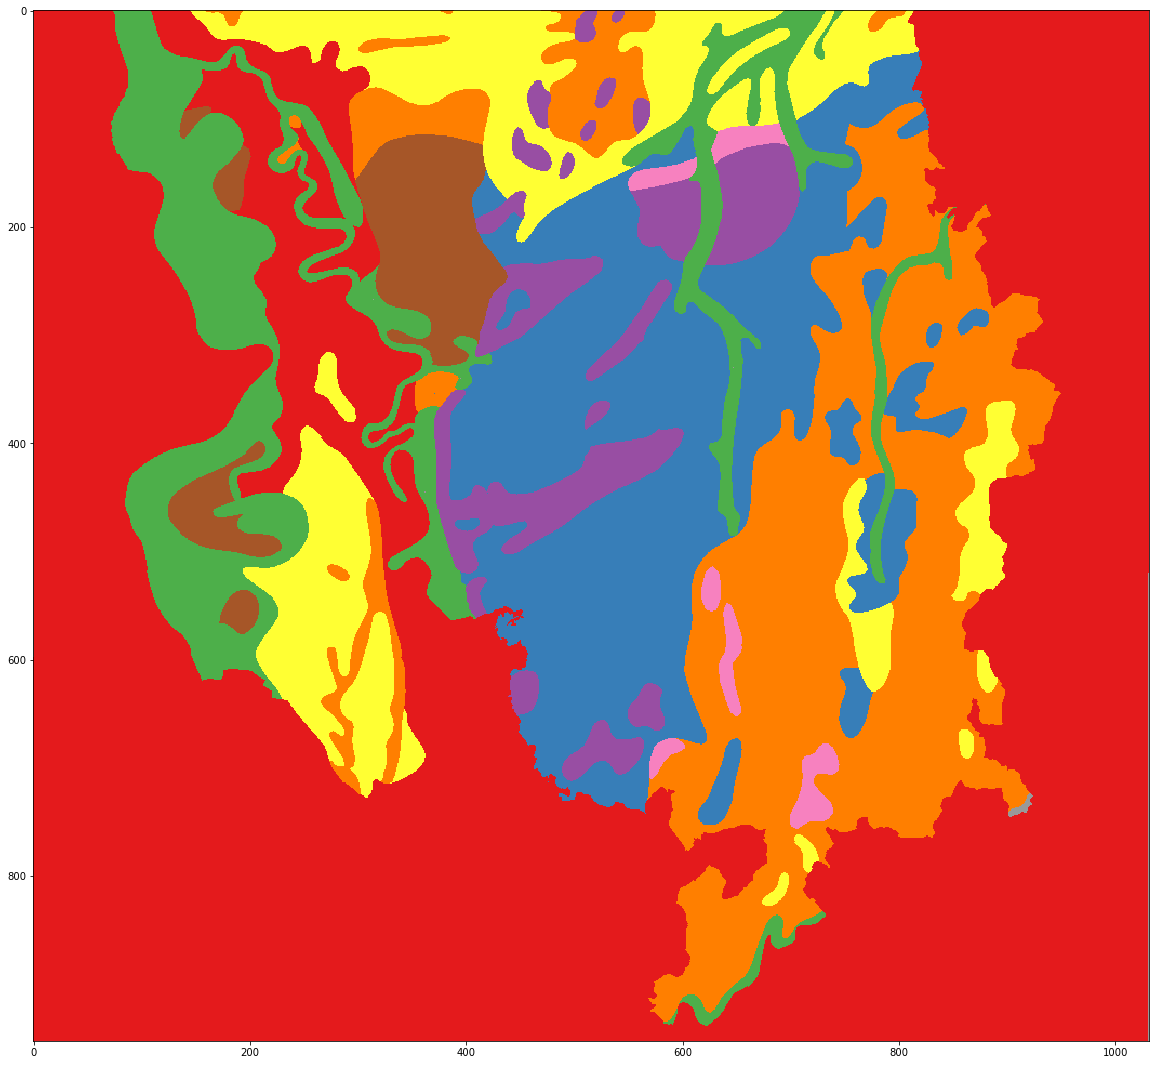

## Save Classification as GeoTiff

In [23]:
#Open input image again to get properties
file = gdal.Open(filepath)

#We need a single band
band = file.GetRasterBand(1)

#Convert it to an array
arr = band.ReadAsArray()

#Extract columns and rows to a list
[cols, rows] = arr.shape

#Set the output as Geotiff
format = "GTiff"
driver = gdal.GetDriverByName(format)

#Creates the output raster with the dimensions of the input raster
outDataRaster = driver.Create("soil_map_middle_classify_30.tiff", rows, cols, 1, gdal.GDT_Byte)

#Set the projection and extent of the data.
outDataRaster.SetGeoTransform(file.GetGeoTransform())##sets same geotransform as input
outDataRaster.SetProjection(file.GetProjection())##sets same projection as input

#Write classification result to a single band raster image 
outDataRaster.GetRasterBand(1).WriteArray(X_cluster)

#Calling FlushCache() to remove from memory and delete the data
outDataRaster.FlushCache() ## remove from memory
del outDataRaster ## delete the data (not the actual geotiff)

In [4]:
#set projection to Geotiff
from osgeo import gdal
path = r'C:\Users\USER\Desktop\master-thesis-master\soil_map\soil_map_great_blank.tiff'
file = gdal.Open(path)
sr = file.GetSpatialRef()
print(sr)

AttributeError: type object 'object' has no attribute '__getattr__'